In [1]:
import os
import tqdm
import fitsio
import numpy as np
from scipy.special import erf
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [2]:
os.sys.path.append(os.getcwd().replace('/nb', '/bin'))
import svda as SVDA

In [3]:
import corner as DFM
import matplotlib.pyplot as plt


Bad key text.latex.preview in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95 

In [4]:
# file from /global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/ztile-sv3-bright-cumulative.fits
# fuji couldn't be downloaded for some reason
ff = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/fuji/zcatalog/ztile-sv3-bright-cumulative.fits')

In [5]:
# select only BGS targets
is_bgs = ((ff['COADD_FIBERSTATUS'] == 0) & 
          ((ff['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0) & 
          (ff['SPECTYPE'] == 'GALAXY') & 
          (ff['Z'] > 0.) & (ff['Z'] < 0.6))
ff = ff[is_bgs]
print('%i objects' % ff.shape[0])

233831 objects


In [6]:
zsuccess = ((ff['ZWARN'] == 0) & 
            (ff['DELTACHI2'] > 40.) & 
            (ff['ZERR'] < 0.0005 * (1 + ff['Z'])))
print('%i z-success' % np.sum(zsuccess))

229917 z-success


In [7]:
photsys = ff['PHOTSYS'].astype(str)
trans_g = SVDA.mwdust_transmission(ff['EBV'], 'g', photsys, match_legacy_surveys=False)
trans_r = SVDA.mwdust_transmission(ff['EBV'], 'r', photsys, match_legacy_surveys=False)
trans_z = SVDA.mwdust_transmission(ff['EBV'], 'z', photsys, match_legacy_surveys=False)

flux_g = ff['FLUX_G'] / trans_g
flux_r = ff['FLUX_R'] / trans_r
flux_z = ff['FLUX_Z'] / trans_z
fiberflux_r = ff['FIBERFLUX_R'] / trans_r

In [8]:
gmag = 22.5 - 2.5 * np.log10(flux_g.clip(1e-7))
rmag = 22.5 - 2.5 * np.log10(flux_r.clip(1e-7))
zmag = 22.5 - 2.5 * np.log10(flux_z.clip(1e-7))

rfib = 22.5 - 2.5 * np.log10(fiberflux_r.clip(1e-7))

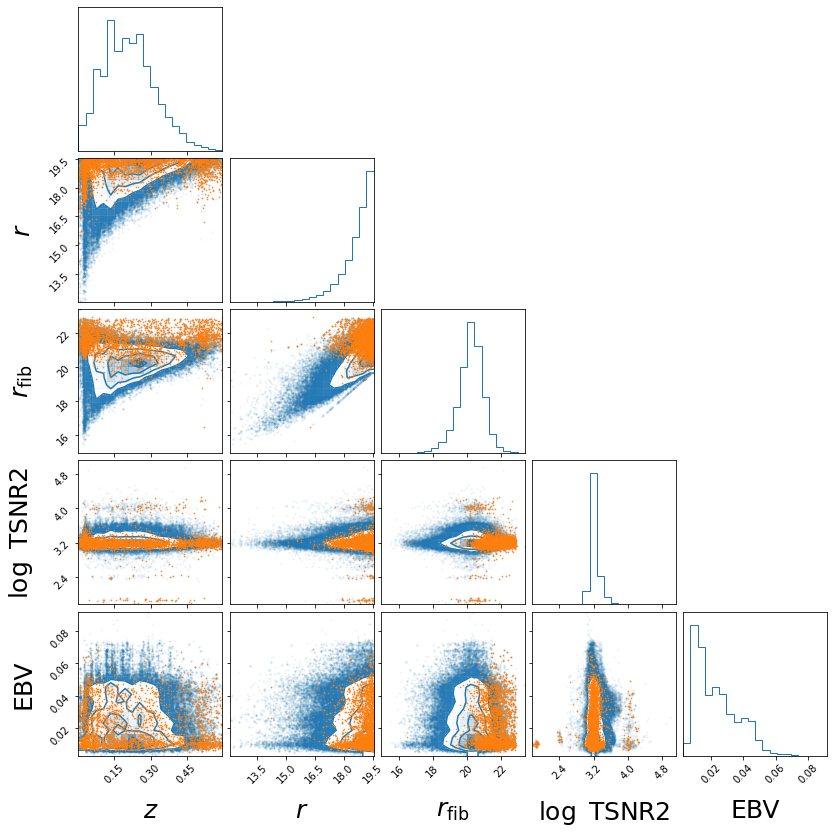

In [9]:
fig = DFM.corner(np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T, 
                 color='C0', hist_kwargs={'density': True}, 
                 labels=[r'$z$', r'$r$', r'$r_{\rm fib}$', r'$\log$ TSNR2', 'EBV'], label_kwargs={'fontsize': 25})
DFM.overplot_points(fig, np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T[~zsuccess], color='C1', markersize=1)
#DFM.overplot_points(fig, np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T[~zsuccess & (np.log10(ff['TSNR2_BGS']) > 3.75)],
#                    color='r', markersize=5)
#DFM.overplot_points(fig, np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T[~zsuccess & (np.log10(ff['TSNR2_BGS']) < 2.4)],
#                    color='green', markersize=5)

(1.5, 5.0)

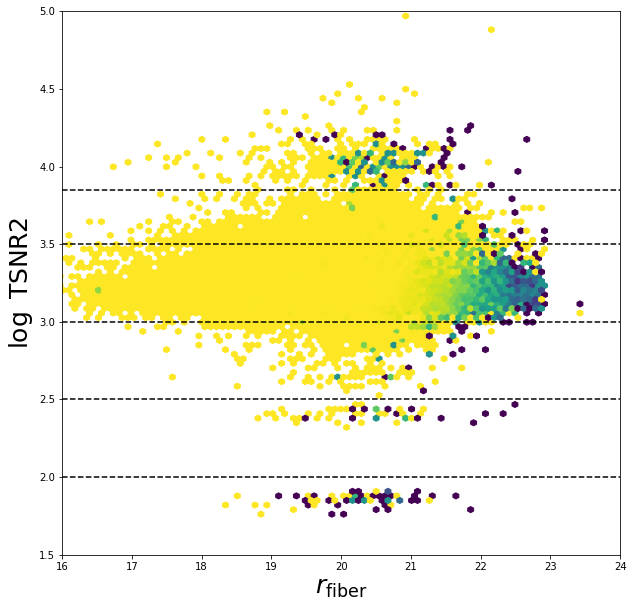

In [33]:
plt.figure(figsize=(10,10))
plt.hexbin(rfib, np.log10(ff['TSNR2_BGS']), C=zsuccess, reduce_C_function=np.mean, 
           gridsize=100, vmin=0.0, vmax=1)
plt.plot([16, 24], [2.0, 2.0], c='k', ls='--')
plt.plot([16, 24], [2.5, 2.5], c='k', ls='--')
plt.plot([16, 24], [3.0, 3.0], c='k', ls='--')
plt.plot([16, 24], [3.5, 3.5], c='k', ls='--')
plt.plot([16, 24], [3.85, 3.85], c='k', ls='--')
plt.xlabel(r'$r_{\rm fiber}$', fontsize=25)
plt.xlim(16, 24)
plt.ylabel(r'$\log$ TSNR2', fontsize=25)
plt.ylim(1.5, 5.)

(3.0, 3.5)

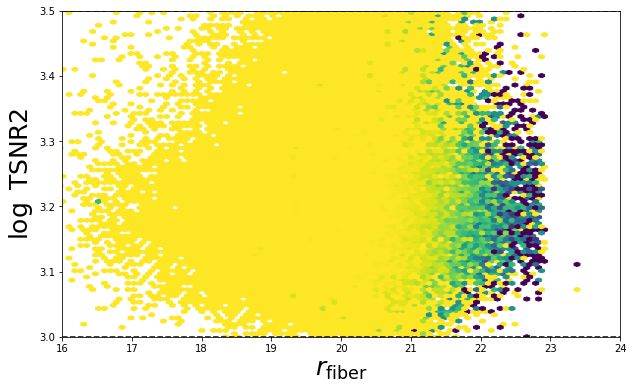

In [19]:
plt.figure(figsize=(10,6))

tsnr2_lim = (np.log10(ff['TSNR2_BGS']) > 3.) & (np.log10(ff['TSNR2_BGS']) < 3.55)
plt.hexbin(rfib[tsnr2_lim], np.log10(ff['TSNR2_BGS'])[tsnr2_lim], C=zsuccess[tsnr2_lim], reduce_C_function=np.mean, gridsize=100, vmin=0.0, vmax=1)
plt.plot([16, 24], [2.5, 2.5], c='k', ls='--')
plt.plot([16, 24], [3.0, 3.0], c='k', ls='--')
plt.plot([16, 24], [3.5, 3.5], c='k', ls='--')
plt.plot([16, 24], [3.85, 3.85], c='k', ls='--')
plt.xlabel(r'$r_{\rm fiber}$', fontsize=25)
plt.xlim(16, 24)
plt.ylabel(r'$\log$ TSNR2', fontsize=25)
plt.ylim(3.0, 3.5)

73 0.3972602739726027
63 0.7301587301587301
1083 0.9695290858725761
225319 0.9835743989632476
6805 0.9950036737692873
487 0.8254620123203286


(16.0, 25.0)

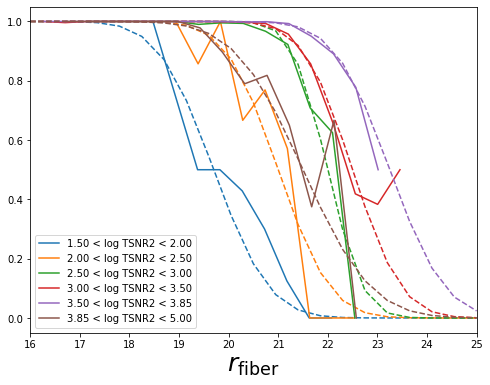

In [41]:
rfib_bin = np.linspace(16, 25, 21)

plt.figure(figsize=(8,6))
for i, logtsnr0, logtsnr1, c_erf0, c_erf1 in zip(range(6), 
                                                 [1.5, 2.0, 2.5, 3.0, 3.5, 3.85], 
                                                 [2.0, 2.5, 3.0, 3.5, 3.85, 5.0], 
                                                 [0.8, 0.85, 1.25, 0.9, 0.8, 0.65], 
                                                 [19.7, 21., 22.0, 22.5, 23.25, 21.5]):
    logtsnr_lim = (np.log10(ff['TSNR2_BGS']) > logtsnr0) & (np.log10(ff['TSNR2_BGS']) < logtsnr1)
    print(np.sum(logtsnr_lim), np.mean(zsuccess[logtsnr_lim]))
    
    ibins = np.digitize(rfib[logtsnr_lim], rfib_bin) - 1

    _rfib, _fz = [], [] 
    for ii in range(20): 
        if np.sum(ibins == ii) > 0: 
            _rfib.append(0.5*(rfib_bin[ii] + rfib_bin[ii+1]))
            _fz.append(np.mean(zsuccess[logtsnr_lim][ibins == ii]))
    plt.plot(np.array(_rfib)+0.01*i, _fz, label='%.2f < log TSNR2 < %.2f' % (logtsnr0, logtsnr1), c='C%i' % i)#0.5*(rfib_bin[1:] + rfib_bin[:-1]), f_zsuccess)
    plt.plot(rfib_bin, 0.5*(1-erf(c_erf0*(rfib_bin - c_erf1))), c='C%i' % i, ls='--')
    
plt.legend(loc='lower left')
plt.xlabel(r'$r_{\rm fiber}$', fontsize=25)
plt.xlim(16, 25)


In [42]:
def fzsuccess_rfib_tsnrbin(rfib, tsnr): 
    logtsnr = np.log10(tsnr)
    
    fz = np.zeros(len(tsnr))
    for logtsnr0, logtsnr1, c_erf0, c_erf1 in zip([1.5, 2.0, 2.5, 3.0, 3.5, 3.85], 
                                                 [2.0, 2.5, 3.0, 3.5, 3.85, 5.0], 
                                                 [0.8, 0.85, 1.25, 0.9, 0.8, 0.65], 
                                                 [19.7, 21., 22.0, 22.5, 23.25, 21.5]):    
        
        logtsnr_lim = (logtsnr > logtsnr0) & (logtsnr < logtsnr1)
        if np.sum(logtsnr_lim) > 0: 
            fz[logtsnr_lim] = 0.5*(1-erf(c_erf0*(rfib[logtsnr_lim] - c_erf1)))
            
    return fz

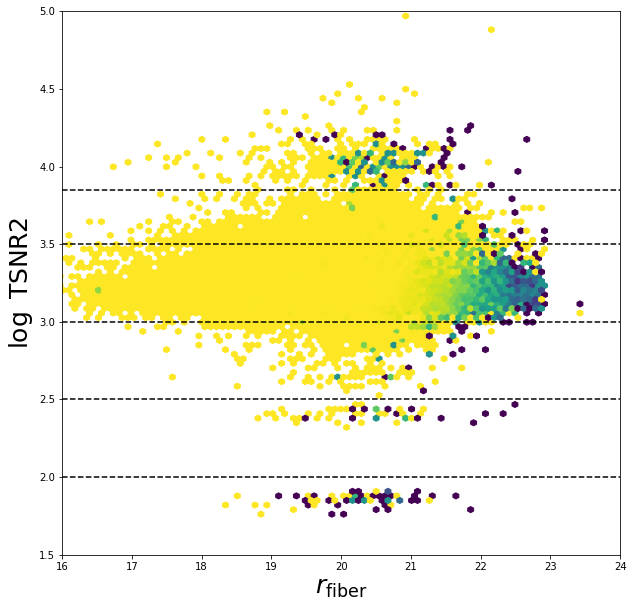

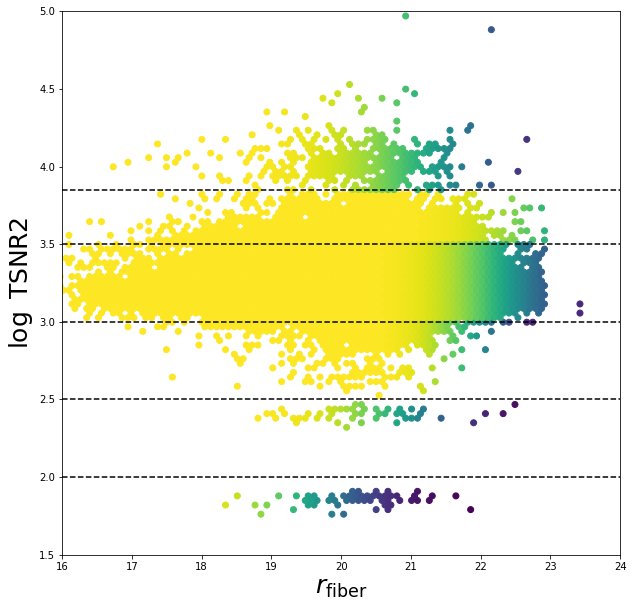

In [45]:
plt.figure(figsize=(10,10))
hexes = plt.hexbin(rfib, np.log10(ff['TSNR2_BGS']), C=zsuccess, reduce_C_function=np.mean, 
           gridsize=100, vmin=0.0, vmax=1)
plt.plot([16, 24], [2.0, 2.0], c='k', ls='--')
plt.plot([16, 24], [2.5, 2.5], c='k', ls='--')
plt.plot([16, 24], [3.0, 3.0], c='k', ls='--')
plt.plot([16, 24], [3.5, 3.5], c='k', ls='--')
plt.plot([16, 24], [3.85, 3.85], c='k', ls='--')
plt.xlabel(r'$r_{\rm fiber}$', fontsize=25)
plt.xlim(16, 24)
plt.ylabel(r'$\log$ TSNR2', fontsize=25)
plt.ylim(1.5, 5.)
plt.show()

xy_bin = hexes.get_offsets()
rfib_bin, log_tsnr_bin = xy_bin[:,0], xy_bin[:,1]

plt.figure(figsize=(10,10))
plt.scatter(rfib_bin, log_tsnr_bin, c=fzsuccess_rfib_tsnrbin(rfib_bin, 10**log_tsnr_bin), vmin=0., vmax=1)
plt.plot([16, 24], [2.0, 2.0], c='k', ls='--')
plt.plot([16, 24], [2.5, 2.5], c='k', ls='--')
plt.plot([16, 24], [3.0, 3.0], c='k', ls='--')
plt.plot([16, 24], [3.5, 3.5], c='k', ls='--')
plt.plot([16, 24], [3.85, 3.85], c='k', ls='--')
plt.xlabel(r'$r_{\rm fiber}$', fontsize=25)
plt.xlim(16, 24)
plt.ylabel(r'$\log$ TSNR2', fontsize=25)
plt.ylim(1.5, 5.)
plt.show()

100%|██████████| 4184/4184 [00:03<00:00, 1365.63it/s]


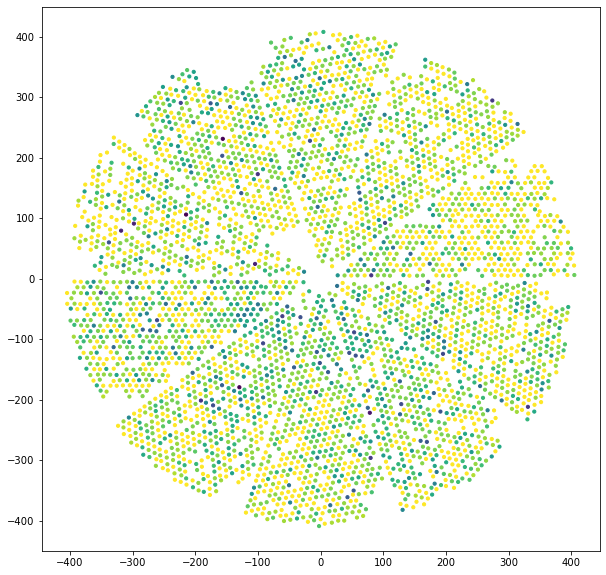

In [46]:
ufid = np.unique(ff['FIBER'])

fid_zsuccess = []
fid_x, fid_y = [], [] 
for fid in tqdm.tqdm(ufid): 
    is_fid = (ff['FIBER'] == fid)
    fid_x.append(np.median(ff['MEAN_FIBER_X'][is_fid]))
    fid_y.append(np.median(ff['MEAN_FIBER_Y'][is_fid]))
    fid_zsuccess.append(np.mean(zsuccess[is_fid]))

fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)
sub.scatter(fid_x, fid_y, s=10, c=fid_zsuccess, vmin=0.9, vmax=1.)